# Project: Investigating Soccer Player Interceptions¶

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This project will check to see if soccer player interceptions have any type of relationship with a player’s preferred foot, player penalties, or a player’s age during a game.

> Specific Questions Include:

> Is there any general data we can gather about a player’s interceptions, player's age, player’s preferred foot, and/or player’s penalties during a game?

> Is there a relationship between player interceptions and player age during a soccer game? Does this difference change when reviewing children (under the age of 18) vs adults (18 and older)

> Is there a relationship between player interceptions and player preferred foot during a soccer game? Does this relationship change between left vs right foot preference?

> Is there a relationship between player interceptions and player penalties foot during a soccer game?

In [92]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline


### Introduction: Dataset Review

> The data for this project was obtained from a Udacity sqlite database (https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True).

> The Udacity database included a table called player_attributes where I was able to obtain values for player interceptions, player's preferred foot, and player penalties. 

> Another table called player was also combine with the player_attributes dataset to add the additional value of birthday. Birthday was used to calculate the player's age during the game.

> The first step in this project is to gather and review the data. 

> I used the Udacity provided database to generate a python panda DataFrame.

In [93]:
# Connect to the soccer database
conn = sqlite3.connect("database.sqlite")

# Read database and save as panda DataFrame
df = pd.read_sql_query("""SELECT player_attributes.player_fifa_api_id,
                                 player_attributes.date,
                                 player_attributes.preferred_foot,
                                 player_attributes.penalties,
                                 player_attributes.interceptions,
                                 player.birthday
                          FROM player_attributes
                          JOIN player ON player_attributes.player_fifa_api_id = player.player_fifa_api_id""", conn)

print(df.head())

# We've got everything we need from the database so close the database connection
conn.close()

   player_fifa_api_id                 date preferred_foot  penalties  \
0              218353  2016-02-18 00:00:00          right       48.0   
1              218353  2015-11-19 00:00:00          right       48.0   
2              218353  2015-09-21 00:00:00          right       48.0   
3              218353  2015-03-20 00:00:00          right       47.0   
4              218353  2007-02-22 00:00:00          right       47.0   

   interceptions             birthday  
0           70.0  1992-02-29 00:00:00  
1           70.0  1992-02-29 00:00:00  
2           41.0  1992-02-29 00:00:00  
3           40.0  1992-02-29 00:00:00  
4           40.0  1992-02-29 00:00:00  


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183929 entries, 0 to 183928
Data columns (total 6 columns):
player_fifa_api_id    183929 non-null int64
date                  183929 non-null object
preferred_foot        183142 non-null object
penalties             183142 non-null float64
interceptions         183142 non-null float64
birthday              183929 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 8.4+ MB


> The dataset includes 6 columns (player_fifa_api_id, date, preferred_foot, penalties, interceptions, birthday) and 183929 rows. 

> Player_fifa_api_id was used to obtain player information but will not be used in the data analysis.

> Date and birthday will be used to create a 7th column (age_during_game) but will not be used during the analysis. 

> The final 4 columns used will include preferred_foot, penalties, interceptions, and age_during_game

<a id='wrangling'></a>
## Data Wrangling

> Once the data was collected, I reviewed the dataset.

> The data had some null values.  These values accounted for less than 2% of the total dataset.  Since the missing values were not significant, I chose to remove the values. 

> The date column and birthday column were transformed from string values to date values.  Since birthday is not a changing number, birthday was used to instead calculate player age at the time of the game date.

> 126 duplicate rows were found in the database and removed from the dataset. 

In [95]:
# Check for missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183929 entries, 0 to 183928
Data columns (total 6 columns):
player_fifa_api_id    183929 non-null int64
date                  183929 non-null object
preferred_foot        183142 non-null object
penalties             183142 non-null float64
interceptions         183142 non-null float64
birthday              183929 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 8.4+ MB
None


In [96]:
# There are 183,929 columns in this data set.  
# It looks like preferred_foot, penalties, and interceptions have missing values.

# Let's take a look at which values are missing.
missing_values = df[df.isnull().any(axis=1)]
print(missing_values.head(100))

       player_fifa_api_id                 date preferred_foot  penalties  \
483                 33022  2007-02-22 00:00:00           None        NaN   
983                111085  2007-02-22 00:00:00           None        NaN   
1752               165740  2007-02-22 00:00:00           None        NaN   
2089               176941  2007-02-22 00:00:00           None        NaN   
2482               177615  2007-02-22 00:00:00           None        NaN   
2498               177713  2007-02-22 00:00:00           None        NaN   
2540                 2115  2007-02-22 00:00:00           None        NaN   
3283               152769  2007-02-22 00:00:00           None        NaN   
4006               172176  2007-02-22 00:00:00           None        NaN   
4202               140307  2007-02-22 00:00:00           None        NaN   
4593               110375  2007-02-22 00:00:00           None        NaN   
4801               178087  2007-02-22 00:00:00           None        NaN   
4998        

In [97]:
# It looks like games on 2/22/2007 have missing data. let's see how many dates in total are missing:
print(missing_values.groupby('date').nunique())

                     player_fifa_api_id  date  preferred_foot  penalties  \
date                                                                       
2007-02-22 00:00:00                 731     1               0          0   
2007-08-30 00:00:00                   1     1               0          0   
2008-08-30 00:00:00                   2     1               0          0   
2009-02-22 00:00:00                   1     1               0          0   
2009-08-30 00:00:00                   2     1               0          0   
2010-02-22 00:00:00                   2     1               0          0   
2010-08-30 00:00:00                   1     1               0          0   
2011-02-22 00:00:00                   1     1               0          0   
2011-08-30 00:00:00                   3     1               0          0   
2012-02-22 00:00:00                   1     1               0          0   
2012-08-31 00:00:00                   2     1               0          0   
2013-02-15 0

In [98]:
# The majority of missing values come from 2/22/2007.  There are also a few missing values on other dates.

# For this project, I am going to drop the null values. 
# Even with the dropped values, our dataset will have 183,142 values left for calcuation which is a large sample size. 
# Also, the missing values account for less than 2% of the original dataset and only one date will be lost.

df.dropna(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183928
Data columns (total 6 columns):
player_fifa_api_id    183142 non-null int64
date                  183142 non-null object
preferred_foot        183142 non-null object
penalties             183142 non-null float64
interceptions         183142 non-null float64
birthday              183142 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ MB
None


In [99]:
# Incorrect Datatypes

# I'm going to change date fields from strings to dates for better data manipulation. 
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])

# Birthday isn't super useful.  What I really want is the player's age during the game
# Stack Overflow helped with the calcuation
df['age_during_game'] =  (df['date'] - df['birthday']).apply(lambda age_in_days: int(float(age_in_days.days)/365))

print(df.head(5))

   player_fifa_api_id       date preferred_foot  penalties  interceptions  \
0              218353 2016-02-18          right       48.0           70.0   
1              218353 2015-11-19          right       48.0           70.0   
2              218353 2015-09-21          right       48.0           41.0   
3              218353 2015-03-20          right       47.0           40.0   
4              218353 2007-02-22          right       47.0           40.0   

    birthday  age_during_game  
0 1992-02-29               23  
1 1992-02-29               23  
2 1992-02-29               23  
3 1992-02-29               23  
4 1992-02-29               14  


In [100]:
# let's check player_fifa_api_id and date.  Ideally, one player should only have one set of scores per game
print(df.groupby(['player_fifa_api_id', 'date']).count().max())

preferred_foot     2
penalties          2
interceptions      2
birthday           2
age_during_game    2
dtype: int64


In [101]:
#  It looks like we have some duplicates in our system.  Let's check and make sure they are full duplicates.

print(df[df.duplicated()].info()) # 126 full diplucates

print()

print(df[df.duplicated(['player_fifa_api_id', 'date'])].info()) # 126 ['player_fifa_api_id', 'date'] duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 7447 to 161452
Data columns (total 7 columns):
player_fifa_api_id    126 non-null int64
date                  126 non-null datetime64[ns]
preferred_foot        126 non-null object
penalties             126 non-null float64
interceptions         126 non-null float64
birthday              126 non-null datetime64[ns]
age_during_game       126 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 7.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 7447 to 161452
Data columns (total 7 columns):
player_fifa_api_id    126 non-null int64
date                  126 non-null datetime64[ns]
preferred_foot        126 non-null object
penalties             126 non-null float64
interceptions         126 non-null float64
birthday              126 non-null datetime64[ns]
age_during_game       126 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 

In [102]:
# Since they are full duplicates, I am going to drop the duplicate values. 
df.drop_duplicates(inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183016 entries, 0 to 183928
Data columns (total 7 columns):
player_fifa_api_id    183016 non-null int64
date                  183016 non-null datetime64[ns]
preferred_foot        183016 non-null object
penalties             183016 non-null float64
interceptions         183016 non-null float64
birthday              183016 non-null datetime64[ns]
age_during_game       183016 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 11.2+ MB
None


<a id='eda'></a>
## Exploratory Data Analysis

### General Data Review

In [103]:
print(df.describe())

       player_fifa_api_id      penalties  interceptions  age_during_game
count        183016.00000  183016.000000  183016.000000    183016.000000
mean         165811.58384      55.001770      52.023189        25.225505
std           53794.51605      15.544212      19.447115         4.739475
min               2.00000       2.000000       1.000000         7.000000
25%          155884.00000      45.000000      34.000000        22.000000
50%          183520.00000      57.000000      57.000000        25.000000
75%          199912.00000      67.000000      68.000000        28.000000
max          234141.00000      96.000000      96.000000        43.000000


> The average penalty during the game was 55

> The average interceptions during a game was 52

> The average age during a game was 25.  The youngest player in a game was 7 which indicates we are using soccer data from a wide variety of matches, including games where children were playing.

### Review Interception Data

> Is there any general data we can gather about a player’s interceptions?

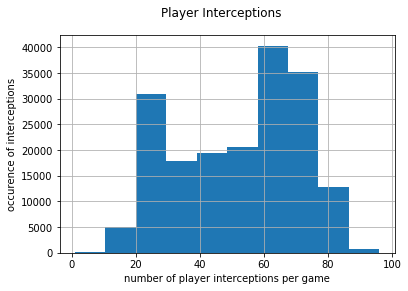

In [104]:
interceptions = df['interceptions'].hist()
interceptions.set_xlabel("number of player interceptions per game")
interceptions.set_ylabel("occurence of interceptions")
plt.suptitle('Player Interceptions');

> It appears interceptions do not have a normal distrubution of values. It's possible to consider that soccer players either complete a lot of interceptions, or they make few interceptions. 

### Review Preferred Foot

> Is there any general data we can gather about a player’s preferred foot?

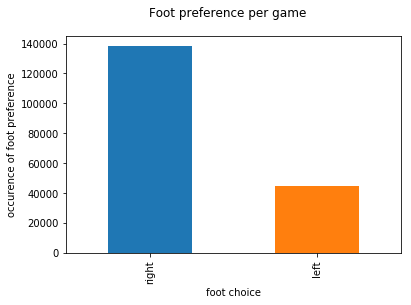

In [105]:
foot = df['preferred_foot'].value_counts().plot(kind='bar')
foot.set_xlabel("foot choice")
foot.set_ylabel("occurence of foot preference")
plt.suptitle('Foot preference per game');

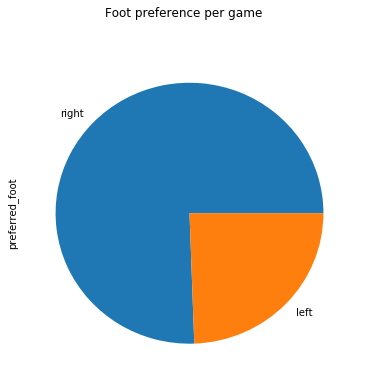

In [106]:
df['preferred_foot'].value_counts().plot(kind='pie', figsize=(6, 6));
plt.suptitle('Foot preference per game');

> A higher number of players prefer using their right foot during a soccer game. 

### Review Penalties
> Is there any general data we can gather about a player’s penalties during a game?

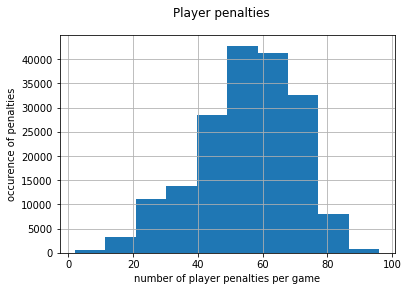

In [107]:
penalties = df['penalties'].hist()
penalties.set_xlabel("number of player penalties per game")
penalties.set_ylabel("occurence of penalties")
plt.suptitle('Player penalties');

> Penalties are slightly skewed with the majority of penalties being between 40 and 80

### Review Age During Game
> Is there any general data we can gather about a player’s age in this dataset?

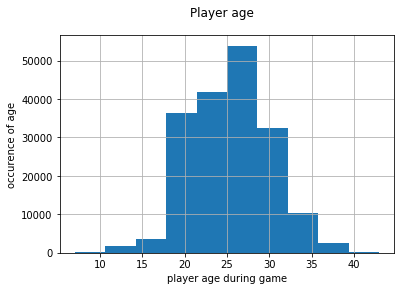

In [108]:
age = df['age_during_game'].hist()
age.set_xlabel("player age during game")
age.set_ylabel("occurence of age")
plt.suptitle('Player age');

> The majority of our players are between the ages of 25 and 30.  Although we have data on some children players, it appears to be a small portion of the data set. 


## Research Question 1:  Interceptions and Age
> Is there a relationship between player interceptions and player age during a soccer game? Does this difference change when reviewing children (under the age of 18) vs adults (18 and older)

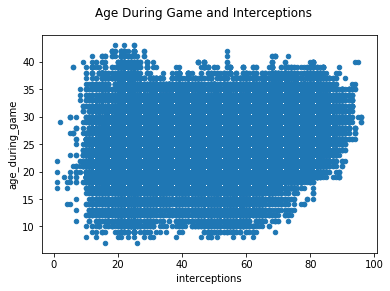

In [110]:
df.plot(x='interceptions', y='age_during_game', kind='scatter')
plt.suptitle('Age During Game and Interceptions');

> Based on the plot, there is no visibile relationship between interceptions and age.

> Let’s also review children (under the age of 18) and adults (18 and older) separately to see if there are any difference.

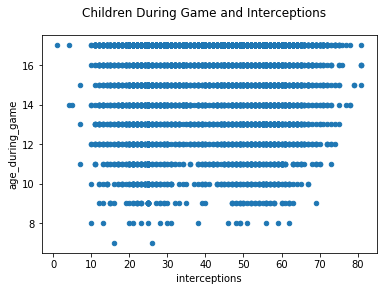

In [112]:
children = df[df['age_during_game'] < 18]

children.plot(x='interceptions', y='age_during_game', kind='scatter')
plt.suptitle('Children During Game and Interceptions');

> Based on the plot, there is no visibile relationship between interceptions and children's age.

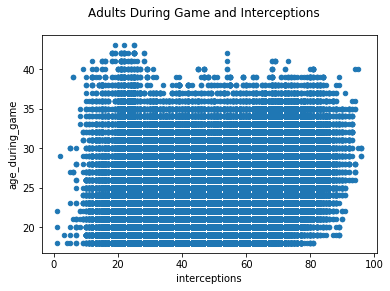

In [115]:
adults = df[df['age_during_game'] >= 18]

adults.plot(x='interceptions', y='age_during_game', kind='scatter')
plt.suptitle('Adults During Game and Interceptions');

> Based on the plot, there is no visibile relationship between interceptions and adult's age.

### Compare Children and Adult interceptions

In [116]:
print(children['interceptions'].describe())
print()
print(adults['interceptions'].describe())

count    5692.000000
mean       41.216971
std        16.368682
min         1.000000
25%        25.000000
50%        43.000000
75%        55.000000
max        81.000000
Name: interceptions, dtype: float64

count    177324.000000
mean         52.370063
std          19.438679
min           1.000000
25%          34.000000
50%          57.000000
75%          68.000000
max          96.000000
Name: interceptions, dtype: float64


> Adults have an interception mean of 52 while children have an interception mean of 41. Adults seem to make more interceptions than children, but it does not seem to be a large difference.

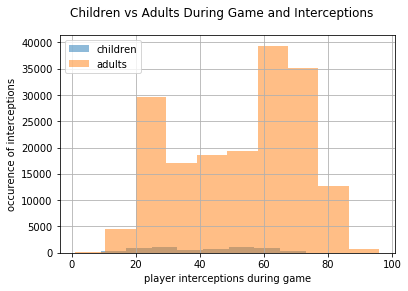

In [121]:
children['interceptions'].hist(alpha=0.5, label='children')
a = adults['interceptions'].hist(alpha=0.5, label='adults')
a.set_xlabel("player interceptions during game")
a.set_ylabel("occurence of interceptions")
plt.legend();
plt.suptitle('Children vs Adults During Game and Interceptions');

> As mentioned before, children make-up a small percent of the overall dataset,  so it’s difficult to compare. However, this chart suggests that children interceptions are more evenly distributed than adult interceptions.


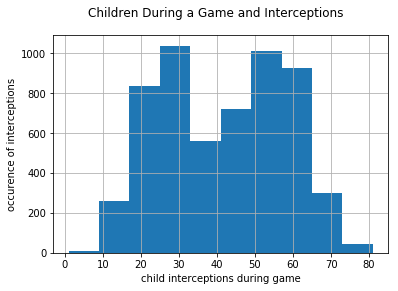

In [123]:
c = children['interceptions'].hist()
c.set_xlabel("child interceptions during game")
c.set_ylabel("occurence of interceptions")
plt.suptitle('Children During a Game and Interceptions');

> However, looking at children alone, it does still seem to mirror the overall trend: interceptions have a bimodal distribution. 

## Research Question 2: Relationship Between Interceptions and Preferred Foot
> Is there a relationship between player interceptions and player preferred foot during a soccer game? Does this relationship change between left vs right foot preference?

In [124]:
print(df.groupby('preferred_foot')['interceptions'].describe())

                   count       mean        std  min   25%   50%   75%   max
preferred_foot                                                             
left             44714.0  54.534486  18.042294  6.0  40.0  59.0  69.0  93.0
right           138302.0  51.211270  19.812163  1.0  32.0  55.0  68.0  96.0


> Players who used their left foot had a average interception rate of 54.  Players who used their right foot had an average interception of 51. This suggests there's not a large difference in player interceptions and player foot choice. 

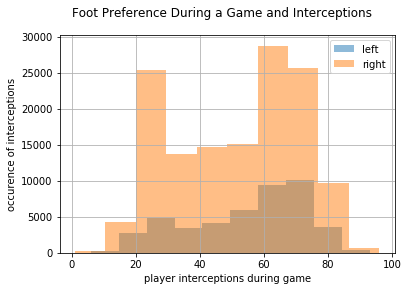

In [126]:
df[df['preferred_foot'] == 'left']['interceptions'].hist(alpha=0.5, label='left')
a = df[df['preferred_foot'] == 'right']['interceptions'].hist(alpha=0.5, label='right')
a.set_xlabel("player interceptions during game")
a.set_ylabel("occurence of interceptions")
plt.legend();
plt.suptitle('Foot Preference During a Game and Interceptions');

> Based on the chart, there doesn’t appear to be a noticable difference in player foot choice and the number of interceptions a player completes. 

## Research Question 3: Relationship Between Interceptions and Penalties
> Is there a relationship between player interceptions and player penalties foot during a soccer game?

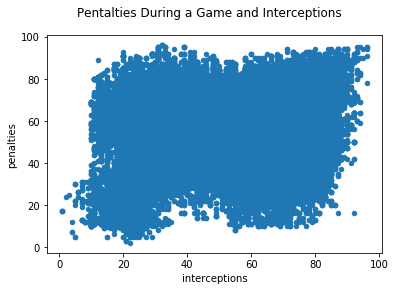

In [129]:
df.plot(x='interceptions', y='penalties', kind='scatter')
plt.suptitle('Pentalties During a Game and Interceptions');

> Based on the plot, there is no visibile relationship between interceptions and penalties.

<a id='conclusions'></a>
## Conclusions

> Based on the data provided, player interceptions does not appear to have a strong relationship with player age, foot preference, or penalties. 

> The biggest finding of this study was that interceptions have a bimodal distribution.  It’s possible that a player leans towards either completing a lot of interceptions during a game, or completing a few interceptions during a game. 

> A secondary finding was that soccer players from this dataset prefer their right foot over their left foot. 

### Limitations
> The dataset was provided to me with little information.  There could be unknown pieces to this dataset, missing populations, or other missing data that would affect my findings. 

> The removed data (including the removed game from 2/22/2007) could include outliers that would affect my final results. 

> These findings were based solely on reviewing means and charts.  This course has not covered statics so a full statistical analysis was beyond the scope of the lessons and this report. More research should be done to further investigate soccer player interceptions.

In [130]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0